
✅ Total Detected Steps: 772

✅ Step Count by Activity:
WALKING: 215 steps
WALKING_UPSTAIRS: 104 steps
WALKING_DOWNSTAIRS: 109 steps


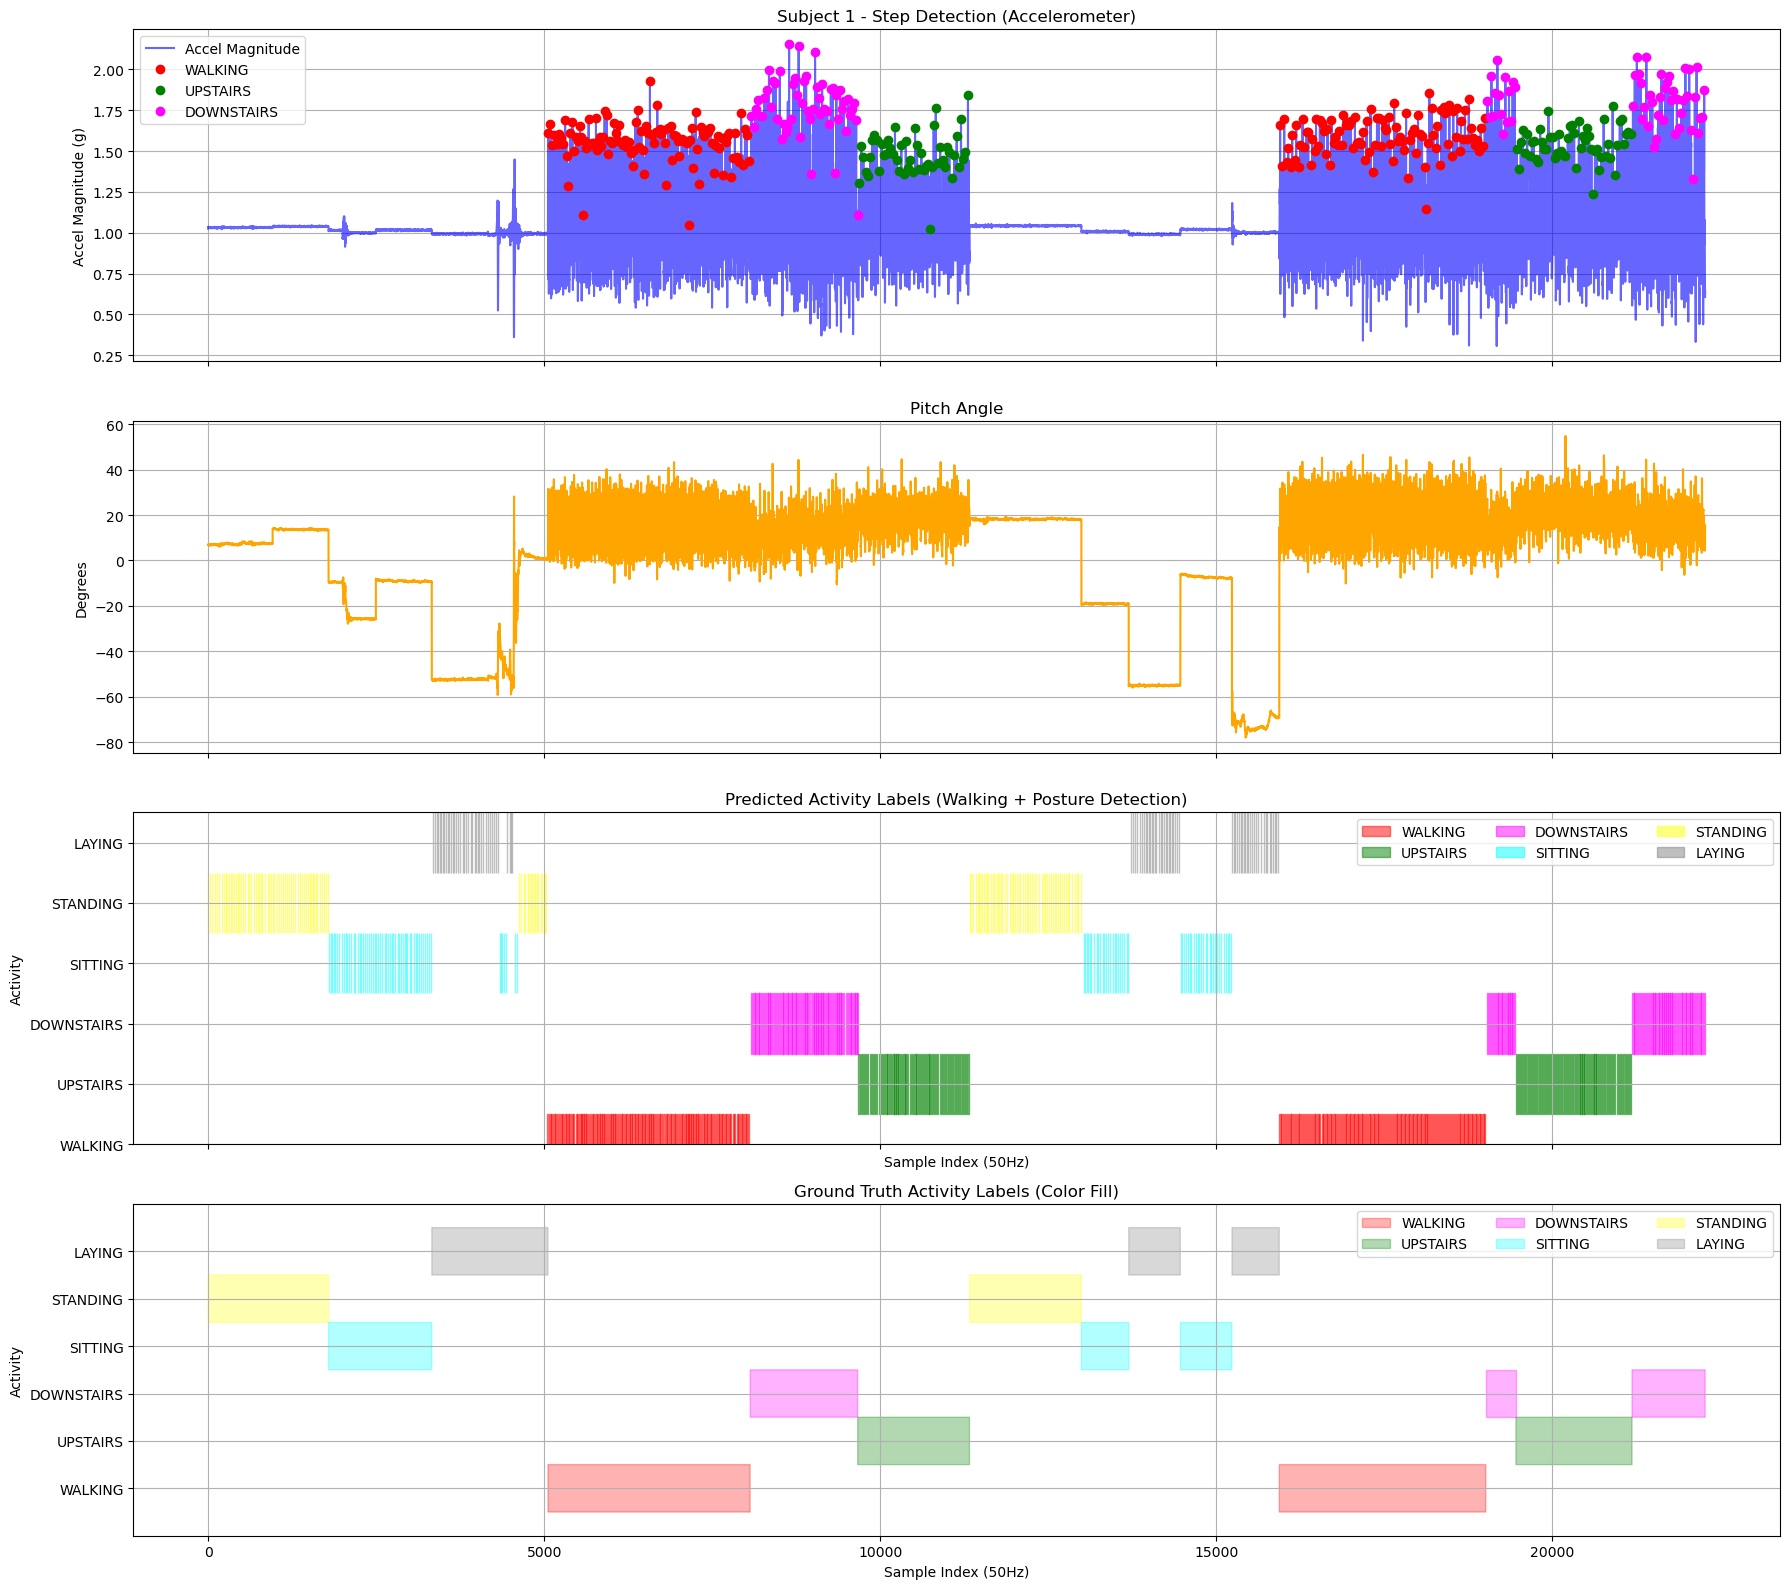

In [6]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import os

# === CONFIG: Select subject ID to test ===
test_subject_id = 1

# === Set Paths ===
base_path = "/Users/temp/Documents/ENGO 623/motion-detection/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/train/"

# === Load Raw Accelerometer Data ===
acc_x = np.loadtxt(os.path.join(base_path, "Inertial Signals/total_acc_x_train.txt"))
acc_y = np.loadtxt(os.path.join(base_path, "Inertial Signals/total_acc_y_train.txt"))
acc_z = np.loadtxt(os.path.join(base_path, "Inertial Signals/total_acc_z_train.txt"))
y_labels = np.loadtxt(os.path.join(base_path, "y_train.txt"), dtype=int)
subject_ids = np.loadtxt(os.path.join(base_path, "subject_train.txt"), dtype=int)

# === Reconstruct Signal from Overlapping Windows ===
def reconstruct_signal(axis_data):
    signal = []
    for i in range(len(axis_data)):
        signal.extend(axis_data[i] if i == 0 else axis_data[i][64:])
    return np.array(signal)

acc_x_signal = reconstruct_signal(acc_x)
acc_y_signal = reconstruct_signal(acc_y)
acc_z_signal = reconstruct_signal(acc_z)

# === Expand Labels and Subject IDs ===
expanded_labels = []
expanded_subjects = []
for i in range(len(y_labels)):
    length = 128 if i == 0 else 64
    expanded_labels.extend([y_labels[i]] * length)
    expanded_subjects.extend([subject_ids[i]] * length)
expanded_labels = np.array(expanded_labels)
expanded_subjects = np.array(expanded_subjects)

# === Filter for Selected Subject ===
acc_xyz = np.stack((acc_x_signal, acc_y_signal, acc_z_signal), axis=1)
acc_labeled = np.hstack((acc_xyz, expanded_labels.reshape(-1, 1), expanded_subjects.reshape(-1, 1)))
subject_acc = acc_labeled[acc_labeled[:, 4] == test_subject_id]
subject_labels = subject_acc[:, 3].astype(int)

# === Compute Acceleration Magnitude & Pitch ===
acc_x = subject_acc[:, 0]
acc_y = subject_acc[:, 1]
acc_z = subject_acc[:, 2]
acc_mag = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
pitch = np.arctan2(-acc_y, np.sqrt(acc_x**2 + acc_z**2)) * (180 / np.pi)

# === Detect Step Peaks ===
peaks, _ = find_peaks(acc_mag, height=0.2, distance=20)

# Count steps by label
step_counts = {1: 0, 2: 0, 3: 0}
for i in peaks:
    label = subject_labels[i]
    if label in step_counts:
        step_counts[label] += 1

print(f"\n✅ Total Detected Steps: {len(peaks)}")
print("\n✅ Step Count by Activity:")
print(f"WALKING: {step_counts[1]} steps")
print(f"WALKING_UPSTAIRS: {step_counts[2]} steps")
print(f"WALKING_DOWNSTAIRS: {step_counts[3]} steps")

# === Initialize Predicted Labels ===
predicted_labels = np.zeros(len(acc_mag), dtype=int)

# === Label Walking Around Peaks ===
for i in peaks:
    label = subject_labels[i]
    if label in [1, 2, 3]:
        start = max(0, i - 10)
        end = min(len(predicted_labels), i + 10)
        predicted_labels[start:end] = label

    elif pitch[i] < -50:
            predicted_labels[i] = 6  # LAYING
    
    elif pitch[i] < -5:
            predicted_labels[i] = 4  # SITTING 
    
    else:
            predicted_labels[i] = 5  # STANDING

# === Plot Results ===
fig, axs = plt.subplots(4, 1, figsize=(18, 16), sharex=True)
x = np.arange(len(predicted_labels))

label_colors = {
    1: 'red', 2: 'green', 3: 'magenta',
    4: 'cyan', 5: 'yellow', 6: 'gray'
}
label_names = {
    1: 'WALKING', 2: 'UPSTAIRS', 3: 'DOWNSTAIRS',
    4: 'SITTING', 5: 'STANDING', 6: 'LAYING'
}

# --- Plot Acceleration and Detected Steps ---
axs[0].plot(acc_mag, label="Accel Magnitude", color='blue', alpha=0.6)
for label, color, name in zip([1, 2, 3], ['red', 'green', 'magenta'], ['WALKING', 'UPSTAIRS', 'DOWNSTAIRS']):
    idx = [i for i in peaks if subject_labels[i] == label]
    axs[0].plot(idx, acc_mag[idx], 'o', label=name, color=color)
axs[0].set_ylabel("Accel Magnitude (g)")
axs[0].set_title(f"Subject {test_subject_id} - Step Detection (Accelerometer)")
axs[0].legend()
axs[0].grid(True)

# --- Plot Pitch ---
axs[1].plot(pitch, label='Pitch Angle (°)', color='orange')
axs[1].set_title("Pitch Angle")
axs[1].set_ylabel("Degrees")
axs[1].grid(True)

# --- Predicted Labels ---
axs[2].set_ylim(3.5, 6.5)
axs[2].set_yticks([1, 2, 3, 4, 5, 6])
axs[2].set_yticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
for label, color in label_colors.items():
    mask = predicted_labels == label
    axs[2].fill_between(x, label - 0.5, label + 0.5, where=mask, color=color, alpha=0.5, label=label_names[label])
axs[2].set_title("Predicted Activity Labels (Walking + Posture Detection)")
axs[2].set_xlabel("Sample Index (50Hz)")
axs[2].set_ylabel("Activity")
axs[2].legend(ncol=3)
axs[2].grid(True)

# --- Ground Truth Labels ---
x_acc = np.arange(len(subject_labels))
axs[3].set_ylim(0, 7)
axs[3].set_yticks([1, 2, 3, 4, 5, 6])
axs[3].set_yticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
for label, color in label_colors.items():
    axs[3].fill_between(x_acc, label - 0.5, label + 0.5, where=(subject_labels == label), color=color, alpha=0.3, label=label_names[label])
axs[3].set_ylabel("Activity")
axs[3].set_xlabel("Sample Index (50Hz)")
axs[3].set_title("Ground Truth Activity Labels (Color Fill)")
axs[3].legend(ncol=3)
axs[3].grid(True)

plt.tight_layout()
plt.show()
